In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.regularizers import L1L2

In [2]:
train_df = pd.read_csv("./input/train.csv")

print("Train shape : ",train_df.shape)


Train shape :  (1306122, 3)


In [3]:
## Config values 
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2019)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=2020)
print("Validation shape : ",val_df.shape)
print("Test shape : ",test_df.shape)
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
oov_tok = "OOV_TOK"
tokenizer = Tokenizer(num_words=max_features) # lower = False, oov_token=oov_tok)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen, truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen, truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen, truncating='post')

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values
test_y = test_df['target'].values

Validation shape :  (130612, 3)
Test shape :  (130613, 3)


In [47]:
regularizer = L1L2(l1=0.0, l2=0.001)
del model
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, trainable=True) (inp) #, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 50, 300)           15000000  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 128)           187392    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total para

In [48]:
# Define callback function if detailed log required

class History(Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_acc = []
        self.val_acc = []
        self.val_loss = []
        for keys in logs:
           print(keys) 

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))
    #Store val_acc/loss per batch    
    def on_epoch_end(self, batch, logs={}):    
        self.val_acc.append(logs.get('val_acc'))
        self.val_loss.append(logs.get('val_loss'))
        
# Compute class_weights for imbalanced train set
def compute_class_weight(input_list):

  class_weights = class_weight.compute_class_weight('balanced', 
                                                   np.unique(input_list),  
                                                   input_list)
                                                   
  return(class_weights)                                                   
        
#define callback functions
history = History()
callbacks = [history]        

class_weights = compute_class_weight(train_y)

class_weights[1] *= 10
print(class_weights)

[ 0.53290517 80.97591407]


In [49]:

model.fit(train_X, train_y, 
          batch_size=512, 
          epochs=2, 
          validation_data=(val_X, val_y), 
          class_weight = class_weights,
          callbacks= callbacks)
model.save('./output/model_self_train_emb.h5')

Train on 1044897 samples, validate on 130612 samples
Epoch 1/2
1044897/1044897 [==============================] - 49s 47us/sample - loss: 0.1211 - acc: 0.9539 - val_loss: 0.1105 - val_acc: 0.9556
Epoch 2/2
1044897/1044897 [==============================] - 50s 47us/sample - loss: 0.0976 - acc: 0.9612 - val_loss: 0.1102 - val_acc: 0.9563


In [35]:
#from tensorflow.keras.models import Model, load_model

#model =load_model('./output/model_glove.h5')
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))

130612/130612 [==============================] - 2s 13us/sample
F1 score at threshold 0.1 is 0.5502095297221791
F1 score at threshold 0.11 is 0.5588632214019211
F1 score at threshold 0.12 is 0.5662963263320088
F1 score at threshold 0.13 is 0.5734473782075121
F1 score at threshold 0.14 is 0.5791421362489486
F1 score at threshold 0.15 is 0.5850380895317983
F1 score at threshold 0.16 is 0.5898048759289035
F1 score at threshold 0.17 is 0.5954986760812003
F1 score at threshold 0.18 is 0.5995081600715404
F1 score at threshold 0.19 is 0.6040986579615525
F1 score at threshold 0.2 is 0.6092672611933437
F1 score at threshold 0.21 is 0.6133060007454342
F1 score at threshold 0.22 is 0.6156605465615708
F1 score at threshold 0.23 is 0.6180097505018641
F1 score at threshold 0.24 is 0.6218007644298224
F1 score at threshold 0.25 is 0.6240454278441355
F1 score at threshold 0.26 is 0.6251794643299173
F1 score at threshold 0.27 is 0.6265036086607858
F1 score at threshold 0.28 is 0.6285395876601996
F1 scor

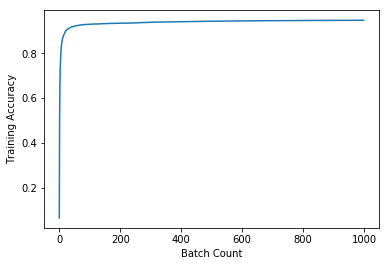

In [39]:
x = range(len(history.train_acc))
%matplotlib inline
fig = plt.figure()
plt.xlabel('Batch Count')
plt.ylabel('Training Accuracy')
plt.plot(x[0:1000], history.train_acc[0:1000])
plt.show()
fig.savefig('self_train_emb_accuracy')

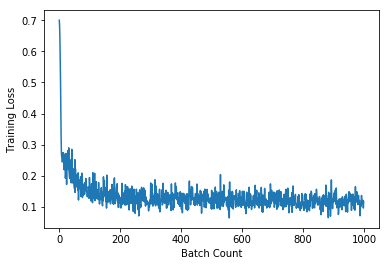

In [40]:
fig = plt.figure()
plt.xlabel('Batch Count')
plt.ylabel('Training Loss')
plt.plot(x[0:1000], history.train_loss[0:1000])
plt.show()
fig.savefig('self_train_emb_loss')

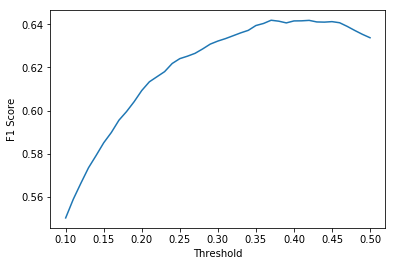

In [42]:

%matplotlib inline
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
fig.savefig('self_train_emb_F1_score')

In [45]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
test_y = test_df['target'].values
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(test_y, (pred_test_y>thresh).astype(int))
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))


130613/130613 [==============================] - 1s 10us/sample
F1 score at threshold 0.1 is 0.5560083032213423
F1 score at threshold 0.11 is 0.5648722986247544
F1 score at threshold 0.12 is 0.57223113964687
F1 score at threshold 0.13 is 0.5786868480261812
F1 score at threshold 0.14 is 0.5857315397109658
F1 score at threshold 0.15 is 0.5912306714679093
F1 score at threshold 0.16 is 0.596867200275411
F1 score at threshold 0.17 is 0.6026846224476411
F1 score at threshold 0.18 is 0.6069859304957613
F1 score at threshold 0.19 is 0.6105557056651355
F1 score at threshold 0.2 is 0.6151528982199909
F1 score at threshold 0.21 is 0.619384686560259
F1 score at threshold 0.22 is 0.6225637181409296
F1 score at threshold 0.23 is 0.6254266211604096
F1 score at threshold 0.24 is 0.627552487776819
F1 score at threshold 0.25 is 0.6305896032168984
F1 score at threshold 0.26 is 0.6343184825760918
F1 score at threshold 0.27 is 0.636192364898364
F1 score at threshold 0.28 is 0.6382403046397435
F1 score at t

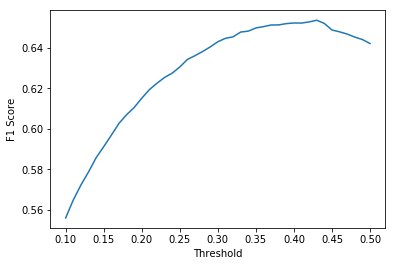

In [46]:
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
fig.savefig('self_train_emb_F1_score')